In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pylab as plt
import time
import csv

seed = 42
np.random.seed(seed)

In [2]:
file = 'Hockey Scores.csv'

results = pd.read_csv(file, parse_dates = True)

print(results)

               Date  Match Number         Home Team  Home Goals  Away Goals  \
0    29th September         662.0      Cheltenham B           5           2   
1    29th September         666.0      Whitchurch B           1           1   
2       6th October         671.0      Whitchurch C           6           0   
3       6th October         672.0   Wotton-u-Edge B           2           7   
4      13th October         675.0             Gwent           3           0   
5      13th October         678.0   Wotton-u-Edge A           4           2   
6      20th October         679.0  Bristol & West A           0           1   
7      20th October         684.0   Wotton-u-Edge B           2           9   
8      27th October         689.0      Whitchurch B           7           2   
9      27th October         690.0   Wotton-u-Edge A           6           1   
10     3rd November         696.0   Wotton-u-Edge B           0           3   
11    10th November         697.0        Bridgend A 

In [3]:
home_goals_scored = results.groupby(['Home Team'])['Home Goals'].mean()
home_goals_conceded = results.groupby(['Home Team'])['Away Goals'].mean()
away_goals_scored = results.groupby(['Away Team'])['Away Goals'].mean()
away_goals_conceded = results.groupby(['Away Team'])['Home Goals'].mean()

team_stats = pd.DataFrame({'Home GF': home_goals_scored, 'Home GA': home_goals_conceded, 'Away GF': away_goals_scored, 'Away GA': away_goals_conceded})
avg_home_goals_scored = results['Home Goals'].mean()
avg_away_goals_scored = results['Away Goals'].mean()

print(team_stats)

lambdas = pd.DataFrame(index=team_stats.index, columns=team_stats.index)

for home_team in lambdas.index:
    for away_team in lambdas.index:
        if home_team != away_team:
            lambdas.loc[home_team, away_team] = (team_stats.loc[home_team]['Home GF'] * team_stats.loc[away_team]['Away GA'] / avg_home_goals_scored, team_stats.loc[away_team]['Away GF'] * team_stats.loc[home_team]['Home GA'] / avg_away_goals_scored)


                   Home GF   Home GA   Away GF   Away GA
Bridgend A        2.090909  3.000000  1.727273  2.727273
Bristol & West A  4.454545  2.363636  1.909091  2.909091
Bristol & West B  2.818182  3.909091  2.545455  3.727273
Cardiff & Met D   1.909091  1.181818  1.363636  4.909091
Cheltenham B      2.727273  1.909091  1.727273  3.000000
Gwent             3.818182  1.454545  2.727273  1.636364
Penarth A         3.272727  1.636364  2.818182  2.363636
Stroud            3.636364  1.181818  3.181818  2.545455
Whitchurch B      2.636364  2.909091  1.636364  3.909091
Whitchurch C      4.454545  1.818182  3.181818  3.090909
Wotton-u-Edge A   3.636364  1.363636  2.181818  1.454545
Wotton-u-Edge B   2.090909  4.272727  2.000000  5.272727


In [4]:
def poisson_prob(lam, k):
    prob = np.exp(-1 * lam) * (lam ** k) / math.factorial(k)
    return prob

def sim_game(lambda_a, lambda_b):
    
    rand_a = np.random.random()
    rand_b = np.random.random()
    
    cum_a = 0
    cum_b = 0
    
    k_a = -1
    k_b = -1
    
    while cum_a < rand_a:
        k_a += 1
        cum_a += poisson_prob(lambda_a, k_a)
        
    while cum_b < rand_b:
        k_b += 1
        cum_b += poisson_prob(lambda_b, k_b)
    
    return (k_a, k_b)

#def get_lambdas(home_team, away_team):

    #lambda_a = team_stats.loc[home_team]['Home GF'] * team_stats.loc[away_team]['Away GA'] / avg_home_goals_scored
    #lambda_b = team_stats.loc[away_team]['Away GF'] * team_stats.loc[home_team]['Home GA'] / avg_away_goals_scored
    #return lambda_a, lambda_b

In [5]:
def sim_game_monte_carlo(home_team, away_team, repeat):

    lambda_a, lambda_b = lambdas.loc[home_team, away_team]
    print('Home Team Lambda: ' + str(round(lambda_a,5)))
    print('Away Team Lambda: ' + str(round(lambda_b,5)))
    
    #running sim n times
    n=0
    results = {}

    while n < repeat:
        n += 1
        result = sim_game(lambda_a, lambda_b)

        if result in results:
            results[result] += 1
        else:
            results[result] = 1


    #Constructing matrix of results        
    res_matrix = pd.DataFrame([0])

    for k, v in results.items():
        x, y = k

        while x >= len(res_matrix.columns):
            res_matrix[str(len(res_matrix.columns))] = 0

        while y >= len(res_matrix.index):
            res_matrix.loc[len(res_matrix.index)]=0

        res_matrix.iloc[y,x] = v

    res_matrix.rename_axis("Home Score", axis="columns")
    res_matrix.rename_axis("Away Score", axis="index")

    return res_matrix

In [6]:
def visualise_results(res_matrix):    
    normalised_res_matrix = res_matrix / res_matrix.values.sum()
    percentage_res_matrix = round(normalised_res_matrix, 2)

    row = len(percentage_res_matrix.index)-1
    while sum(percentage_res_matrix.iloc[row])==0:
        percentage_res_matrix = percentage_res_matrix.drop([row], axis='index')
        row -=1

    col = len(percentage_res_matrix.columns)-1
    while sum(percentage_res_matrix.iloc[:,col])==0:
        percentage_res_matrix = percentage_res_matrix.drop([str(col)], axis='columns')
        col -=1


    ax = sns.heatmap(percentage_res_matrix)
    ax.invert_yaxis()
    ax.set(xlabel='Home Score', ylabel='Away Score')
    ax.set_title(home_team + ' Vs. ' + away_team)
    plt.show()

In [7]:
def sim_season(team_stats):
    table = pd.DataFrame({'P':0, 'W':0, 'D':0, 'L':0, 'GF':0, 'GA':0}, index=list(team_stats.index))

    for home_team in team_stats.index:    
        for away_team in team_stats.index:
            if home_team != away_team:
                la , lb = lambdas.loc[home_team, away_team]
                res = sim_game(la, lb)

                home_score, away_score = res

                #Update table
                table.loc[home_team, 'P'] += 1
                table.loc[home_team, 'GF'] += home_score
                table.loc[home_team, 'GA'] += away_score

                table.loc[away_team, 'P'] += 1
                table.loc[away_team, 'GF'] += away_score
                table.loc[away_team, 'GA'] += home_score

                if home_score > away_score:
                    table.loc[home_team, 'W'] += 1
                    table.loc[away_team, 'L'] += 1

                elif home_score == away_score:
                    table.loc[home_team, 'D'] += 1
                    table.loc[away_team, 'D'] += 1

                else:
                    table.loc[home_team, 'L'] += 1
                    table.loc[away_team, 'W'] += 1

    #Finishing table                
    table['GD'] = table['GF'] - table['GA']
    table['Pts'] = table['W']*3 + table['D']

    table = table.sort_values(by=['Pts', 'GD', 'GF', 'W'], ascending=[False, False, False, False])
    return table

In [8]:
def sim_season_monte_carlo(team_stats, repeat):
    
    #Construct df to hold results
    results = pd.DataFrame({1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}, index=list(team_stats.index))

    n = 0
    while n < repeat:
        n += 1

        table = sim_season(team_stats)

        m = 0
        for team in table.index:
            m += 1
            results.loc[team, m] += 1
    
    return results

In [9]:
#Estimating outcome of a game: B&W B Vs B&W A

#home_team = 'Bristol & West B'
#away_team = 'Bristol & West A'

#res_matrix = sim_game_monte_carlo(home_team, away_team, 100000)
#res_matrix

In [10]:
#visualise_results(res_matrix)

In [11]:
#start_time = time.time()

#repeat = 5

#results = sim_season_monte_carlo(team_stats, repeat)

#end_time = time.time()
#print('Time elapsed: ' + str(end_time - start_time) + ' sec')
#print('Seasons per second: ' + str(repeat/(end_time - start_time))) #5.84

#results_normalised = results / repeat

#timestr = time.strftime("%y%m%d-%H%M%S")
#results.to_csv('Output/hockey_' + str(seed) + '_' + timestr + '.csv')

In [12]:
def sim_results(team_stats, seasons):
    
    np.random.seed(seed)
    timestr = time.strftime("%y%m%d-%H%M%S")
    
    start_time = time.time()
    
    filename = 'Output/results_list_' + str(seed) + '_' + timestr + '.csv'
    
    with open(filename, 'w') as file:
    
        
        n=0
        while n < seasons:
            n+=1
            game = 0
            for home_team in team_stats.index:
                for away_team in team_stats.index:
                    if home_team != away_team:

                        game += 1
                        lambda_a, lambda_b = lambdas.loc[home_team, away_team]
                        home_goals, away_goals = sim_game(lambda_a, lambda_b)
                        
                        l = n, home_team, home_goals, away_team, away_goals
                        
                        for val in l:
                            file.write(str(val)+',')
                            
                        file.write('\n')
    
    end_time = time.time()
    
    print('Results saved to ' + filename)
    print('Time elapsed: ' + str(end_time - start_time) + ' sec')
    print('Seasons per second: ' + str(seasons/(end_time - start_time))) #2.7                

In [13]:


seasons = 1000000

#results_list = sim_results(team_stats, seasons)



In [14]:
def read_results(filename, teamlist, firstseason, lastseason):
    
    results = pd.DataFrame({1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}, index=list(teamlist))
    table = pd.DataFrame({'W':0, 'D':0, 'L':0, 'GF':0, 'GA':0}, index=list(teamlist))
    curr_season = 1
    
    with open(filename, 'r') as file:
        readcsv = csv.reader(file, delimiter=',')
        for row in readcsv:
            
            if int(row[0]) > lastseason:
                
                #Finishing table                
                table['GD'] = table['GF'] - table['GA']
                table['Pts'] = table['W']*3 + table['D']

                table = table.sort_values(by=['Pts', 'GD', 'GF', 'W'], ascending=[False, False, False, False])

                #Update results df
                m = 0
                for team in teamlist:
                    m += 1
                    results.loc[team, m] += 1
                
                return results
            
            elif int(row[0]) >= firstseason:
                
                if int(row[0]) > curr_season:
                    
                    #Finishing table                
                    table['GD'] = table['GF'] - table['GA']
                    table['Pts'] = table['W']*3 + table['D']

                    table = table.sort_values(by=['Pts', 'GD', 'GF', 'W'], ascending=[False, False, False, False])
                    
                    #Update results df
                    m = 0
                    for team in table.index:
                        m += 1
                        results.loc[team, m] += 1
                    
                    table = pd.DataFrame({'W':0, 'D':0, 'L':0, 'GF':0, 'GA':0}, index=list(teamlist))
                    
                curr_season = int(row[0])

                home_team = row[1]
                home_score = int(row[2])
                away_team = row[3]
                away_score = int(row[4])

                #Update table



                table.loc[home_team, 'GF'] += home_score
                table.loc[home_team, 'GA'] += away_score

                table.loc[away_team, 'GF'] += away_score
                table.loc[away_team, 'GA'] += home_score

                if home_score > away_score:
                    table.loc[home_team, 'W'] += 1
                    table.loc[away_team, 'L'] += 1

                elif home_score == away_score:
                    table.loc[home_team, 'D'] += 1
                    table.loc[away_team, 'D'] += 1

                else:
                    table.loc[home_team, 'L'] += 1
                    table.loc[away_team, 'W'] += 1
                    
                

    return results

In [15]:
start_time = time.time()

filename = 'Output/results_list_42_190414-232623.csv'
teamlist = team_stats.index
firstseason = 1
lastseason = 100
seasons = lastseason - firstseason + 1



results = read_results(filename, teamlist, firstseason, lastseason)
print(results)

end_time = time.time()

print('Time elapsed: ' + str(end_time - start_time) + ' sec')
print('Seasons per second: ' + str(seasons/(end_time - start_time))) #8.8          

                  1   2   3   4   5   6   7   8   9   10  11  12
Bridgend A         1   0   0   0   0   6  14  20  12  20  21   6
Bristol & West A   0   2   3  10  20  40  17   6   2   0   0   0
Bristol & West B   0   0   1   0   0   1   6  14  30  22  22   4
Cardiff & Met D    0   0   0   1   0   5  15  24  22  20  10   3
Cheltenham B       0   0   0   0   7  20  32  22  12   5   1   1
Gwent             41  23  16   9  10   1   0   0   0   0   0   0
Penarth A          4   7  28  16  25  10   9   1   0   0   0   0
Stroud            22  30  15  22   9   1   0   1   0   0   0   0
Whitchurch B       0   0   0   0   0   0   3  12  21  27  30   7
Whitchurch C       3  20  17  18  25  12   4   0   0   1   0   0
Wotton-u-Edge A   29  18  20  24   4   4   0   0   0   0   1   0
Wotton-u-Edge B    0   0   0   0   0   0   0   0   1   5  15  79
Time elapsed: 12.943997621536255 sec
Seasons per second: 7.725588564202125


In [16]:
results_normalised = results / seasons
results_normalised

,1,2,3,4,5,6,7,8,9,10,11,12
Bridgend A,0.01,0.00,0.00,0.00,0.00,0.06,0.14,0.20,0.12,0.20,0.21,0.06
Bristol & West A,0.00,0.02,0.03,0.10,0.20,0.40,0.17,0.06,0.02,0.00,0.00,0.00
Bristol & West B,0.00,0.00,0.01,0.00,0.00,0.01,0.06,0.14,0.30,0.22,0.22,0.04
Cardiff & Met D,0.00,0.00,0.00,0.01,0.00,0.05,0.15,0.24,0.22,0.20,0.10,0.03
Cheltenham B,0.00,0.00,0.00,0.00,0.07,0.20,0.32,0.22,0.12,0.05,0.01,0.01
Gwent,0.41,0.23,0.16,0.09,0.10,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Penarth A,0.04,0.07,0.28,0.16,0.25,0.10,0.09,0.01,0.00,0.00,0.00,0.00
Stroud,0.22,0.30,0.15,0.22,0.09,0.01,0.00,0.01,0.00,0.00,0.00,0.00
Whitchurch B,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.12,0.21,0.27,0.30,0.07
Whitchurch C,0.03,0.20,0.17,0.18,0.25,0.12,0.04,0.00,0.00,0.01,0.00,0.00


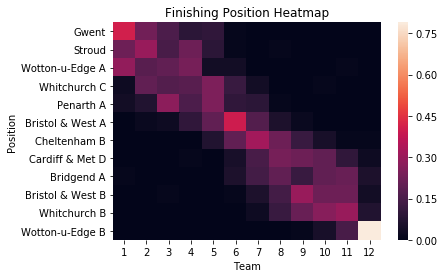

In [17]:
results_normalised['avg_position'] = results_normalised.dot(results_normalised.columns)
results_normalised_sorted = results_normalised.sort_values(by=['avg_position'])

results_normalised = results_normalised.drop(columns='avg_position')
avg_position = results_normalised_sorted.pop('avg_position')

ax = sns.heatmap(results_normalised_sorted)
ax.set(xlabel='Team', ylabel='Position')
ax.set_title('Finishing Position Heatmap')
plt.show()

In [18]:
print(avg_position)

Gwent                2.27
Stroud               2.74
Wotton-u-Edge A      2.76
Whitchurch C         4.01
Penarth A            4.22
Bristol & West A     5.78
Cheltenham B         7.36
Cardiff & Met D      8.75
Bridgend A           9.06
Bristol & West B     9.43
Whitchurch B         9.90
Wotton-u-Edge B     11.72
Name: avg_position, dtype: float64
